# Importing Libraries

In [2]:
import librosa
import matplotlib.pyplot as plt
import numpy as np
import os
import csv
from keras import layers, models
import scipy.io.wavfile as wav
from snr_calculator import calculate_snr


In [3]:
# Path to the data folders
data_folder = 'Data'

clean_path = os.path.join(data_folder, 'CleanSpeech_training')
noisy_path = os.path.join(data_folder, 'NoisySpeech_training')

noise_path = os.path.join(data_folder, 'Noise_training')

In [4]:
def load_audio_file(file_path):
    input_length = 160000
    data, _ = librosa.core.load(file_path)  # Unpack the tuple here
    if len(data)>input_length:
        data = data[:input_length]
    else:
        data = np.pad(data, (0, max(0, input_length - len(data))), "constant")
    return data



**Exploring the Dataset**


In [5]:
# Load a clean speech sample
clean_file = os.path.join(clean_path, 'clnsp1.wav')
clean_audio = load_audio_file(clean_file)

# Load a noisy speech sample
noisy_file = os.path.join(noisy_path, 'noisy1_SNRdb_0.0_clnsp1.wav')
noisy_audio= load_audio_file(noisy_file)

# Load a noise sample
noise_file = os.path.join(noise_path, 'noisy1_SNRdb_0.0.wav')
noise_audio = load_audio_file(noise_file)

**Visualizing Waveforms**

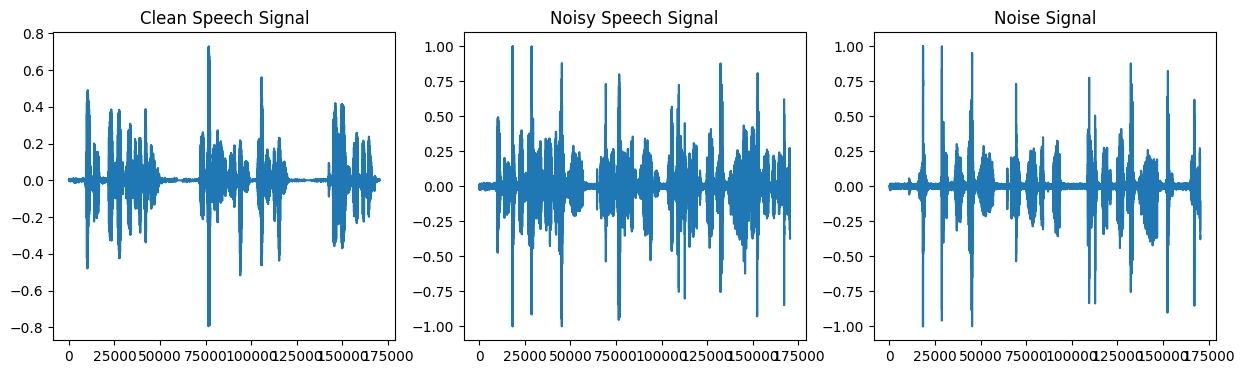

In [10]:
# Visualize the waveforms
plt.figure(figsize=(15, 4))

plt.subplot(1, 3, 1)
plt.plot(clean_audio)
plt.title('Clean Speech Signal')

plt.subplot(1, 3, 2)
plt.plot(noisy_audio)
plt.title('Noisy Speech Signal')

plt.subplot(1, 3, 3)
plt.plot(noise_audio)
plt.title('Noise Signal')

plt.show()

**SPECTOGRAMS**

Purpose: A spectrogram is a 2D representation of the frequency content of a signal over time. It provides a way to visualize how the energy in different frequency bands changes as the audio signal progresses.

Insights: Spectrograms are particularly useful for analyzing the frequency composition of speech and noise. They help in identifying patterns, such as formants in speech or specific frequency components in noise. Spectrograms also reveal changes in frequency content over time, which can be critical for understanding dynamic characteristics.

C:\Users\shiva\AppData\Local\Temp\ipykernel_6452\3386176371.py:19: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(clean_times, clean_freqs, 10 * np.log10(clean_Sxx), shading='gouraud')
C:\Users\shiva\AppData\Local\Temp\ipykernel_6452\3386176371.py:24: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(noisy_times, noisy_freqs, 10 * np.log10(noisy_Sxx), shading='gouraud')
C:\Users\shiva\AppData\Local\Temp\ipykernel_6452\3386176371.py:29: RuntimeWarning: divide by zero encountered in log10
  plt.pcolormesh(noise_times, noise_freqs, 10 * np.log10(noise_Sxx), shading='gouraud')


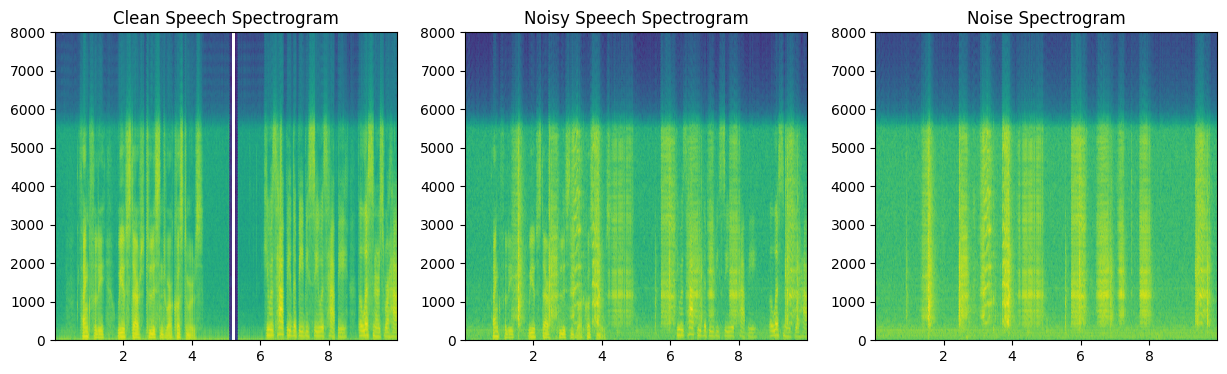

In [7]:
from scipy.signal import spectrogram

# Function to compute the spectrogram
def compute_spectrogram(signal, nperseg=400, noverlap=200):
    sr = 16000
    freqs, times, Sxx = spectrogram(signal, fs=sr, nperseg=nperseg, noverlap=noverlap)
    return freqs, times, Sxx

# Compute the spectrograms
clean_freqs, clean_times, clean_Sxx = compute_spectrogram(clean_audio)
noisy_freqs, noisy_times, noisy_Sxx = compute_spectrogram(noisy_audio)
noise_freqs, noise_times, noise_Sxx = compute_spectrogram(noise_audio)

# Visualize the spectrograms
plt.figure(figsize=(15, 4))

# Clean speech spectrogram
plt.subplot(1, 3, 1)
plt.pcolormesh(clean_times, clean_freqs, 10 * np.log10(clean_Sxx), shading='gouraud')
plt.title('Clean Speech Spectrogram')

# Noisy speech spectrogram
plt.subplot(1, 3, 2)
plt.pcolormesh(noisy_times, noisy_freqs, 10 * np.log10(noisy_Sxx), shading='gouraud')
plt.title('Noisy Speech Spectrogram')

# Noise spectrogram
plt.subplot(1, 3, 3)
plt.pcolormesh(noise_times, noise_freqs, 10 * np.log10(noise_Sxx), shading='gouraud')
plt.title('Noise Spectrogram')

plt.show()

plt.show()

**DATA PRE-PROCESSING**


Normalizing a spectrogram is a process of scaling its values to a consistent range, typically between 0 and 1. This is done to ensure that the input data to a neural network falls within a certain numerical range, making it easier for the network to learn and preventing numerical instability during training

In [10]:
from scipy.signal import spectrogram
def generate_spectrogram(signal, nperseg=400, noverlap=200):
    sr = 16000
    freqs, times, Sxx = spectrogram(signal, fs=sr, nperseg=nperseg, noverlap=noverlap)
    return Sxx

In [6]:
def normalize_spectrogram(Sxx):
    return np.log1p((Sxx - np.mean(Sxx)) / np.std(Sxx))

In [7]:
# Function to prepare input-output pairs
def prepare_data(clean_path, noise_path, noisyspeech_path, target_shape=(257, 315)):
    input_data = []
    target_data = []

    for idx in range(1, 64):  # Assuming there are 63 files
        for snr in range(0, 41, 10):
            # Construct clean and noise file names
            clean_filename = f'clnsp{idx}.wav'
            noise_filename = f'noisy{idx}_SNRdb_{snr:.1f}.wav'
            noisyspeech_filename = f'noisy{idx}_SNRdb_{snr:.1f}_clnsp{idx}.wav'
            
            # Load clean, noise, and noisy speech audio
            # Load clean, noise, and noisy speech audio
            clean_audio = load_audio_file(os.path.join(clean_path, clean_filename))
            
            
            noise_audio = load_audio_file(os.path.join(noise_path, noise_filename))
            
            
            noisyspeech_audio = load_audio_file(os.path.join(noisyspeech_path, noisyspeech_filename))
            

            # Generate spectrograms
            clean_spec = generate_spectrogram(clean_audio)
            noise_spec = generate_spectrogram(noise_audio)
            noisyspeech_spec = generate_spectrogram(noisyspeech_audio)

            # Normalize spectrograms
            normalized_clean_spec = normalize_spectrogram(clean_spec)
            normalized_noisy_spec = normalize_spectrogram(noisyspeech_spec)

            # Resize spectrograms to the target shape
            normalized_clean_spec = np.resize(normalized_clean_spec, target_shape)
            normalized_noisy_spec = np.resize(normalized_noisy_spec, target_shape)

            # Use the noisy spectrogram as input and the clean spectrogram as target
            input_data.append(normalized_noisy_spec)
            target_data.append(normalized_clean_spec)

    return np.array(input_data), np.array(target_data)

In [11]:
# Define the desired target shape
target_shape = (257, 315)

# Prepare the data
input_data, target_data = prepare_data(clean_path, noise_path, noisy_path, target_shape=target_shape)

print(f'Input data shape: {input_data.shape}')
print(f'Target data shape: {target_data.shape}')
# first 10 samples
print(input_data[0:10])


Input data shape: (315, 257, 315)
Target data shape: (315, 257, 315)
[[[-0.0756273  -0.07426392 -0.07547551 ... -0.03750639 -0.06898887
   -0.04562787]
  [-0.06582779 -0.03322709 -0.07555804 ... -0.06897491 -0.07544736
   -0.06805667]
  [-0.07483738 -0.07218942 -0.07548997 ... -0.06896791 -0.03730274
   -0.02983867]
  ...
  [-0.07469835 -0.07531666 -0.07402489 ... -0.07548785 -0.07563475
   -0.07555714]
  [-0.07557959 -0.07565834 -0.07564707 ... -0.0725266  -0.06792681
   -0.07396928]
  [-0.07422011 -0.07112573 -0.06083168 ... -0.07382231 -0.07507713
   -0.04812353]]

 [[-0.0582233  -0.0571931  -0.05810083 ... -0.01961991 -0.04029724
   -0.02249471]
  [-0.0437698  -0.01205545 -0.05786206 ... -0.05108545 -0.05823101
   -0.05007651]
  [-0.05754784 -0.0568374  -0.05822803 ... -0.0533295  -0.00664109
   -0.02005053]
  ...
  [-0.05793285 -0.05812415 -0.05769216 ... -0.05818212 -0.0582311
   -0.05820501]
  [-0.0582123  -0.0582391  -0.05823506 ... -0.05499727 -0.05016932
   -0.05651415]
  [-0

In [12]:
from sklearn.model_selection import train_test_split

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(input_data, target_data, test_size=0.2, random_state=42)


In [13]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Reshape

# Define the model architecture
model = Sequential()

# CNN part
model.add(Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(257, 315, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Flatten layer
model.add(Flatten())

# Dense layers for regression
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))

# Final Dense layer to match the original shape
model.add(Dense(257*315))

# Reshape back to the original shape
model.add(Reshape((257, 315, 1)))

# Compile the model
model.compile(optimizer='adam', loss='mse')


In [14]:
# Train the model
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, batch_size=32)


Epoch 1/10

8/8 [==============================] - 17s 1s/step - loss: 0.0637 - val_loss: 0.0577
Epoch 2/10
8/8 [==============================] - 29s 4s/step - loss: 0.0557 - val_loss: 0.0534
Epoch 3/10
8/8 [==============================] - 12s 1s/step - loss: 0.0533 - val_loss: 0.0523
Epoch 4/10
8/8 [==============================] - 12s 1s/step - loss: 0.0526 - val_loss: 0.0521
Epoch 5/10
8/8 [==============================] - 11s 1s/step - loss: 0.0523 - val_loss: 0.0519
Epoch 6/10
8/8 [==============================] - 11s 1s/step - loss: 0.0521 - val_loss: 0.0517
Epoch 7/10
8/8 [==============================] - 11s 1s/step - loss: 0.0519 - val_loss: 0.0515
Epoch 8/10
8/8 [==============================] - 12s 1s/step - loss: 0.0518 - val_loss: 0.0513
Epoch 9/10
8/8 [==============================] - 11s 1s/step - loss: 0.0514 - val_loss: 0.0509
Epoch 10/10
8/8 [==============================] - 11s 1s/step - loss: 0.0510 - val_loss: 0.0505


**TESTING THE MODEL**


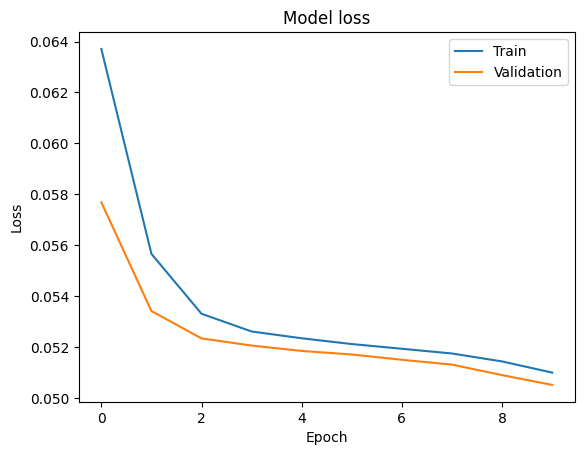

In [15]:

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


In [17]:

def calculate_snr(clean_spec, noisy_spec):
    # Calculate the power of the clean and noisy spectrograms
    clean_power = np.sum(np.abs(clean_spec) ** 2)
    noise_power = np.sum(np.abs(noisy_spec - clean_spec) ** 2)

    # Calculate the SNR in decibels (dB)
    snr = 10 * np.log10(clean_power / noise_power)

    return snr


In [27]:
import random
import re
import soundfile as sf


# Select a random file from the testing folder
test_files = os.listdir('Data/NoisySpeech_testing')
random_file = random.choice(test_files)

# Extract the original SNR from the file name
original_snr = float(random_file.split('_')[2])

# Load the noisy speech audio
noisy_audio = load_audio_file(os.path.join('Data/NoisySpeech_testing', random_file))

# Generate and normalize the spectrogram
noisy_spec = generate_spectrogram(noisy_audio)
normalized_noisy_spec = normalize_spectrogram(noisy_spec)

# Reshape the spectrogram for prediction
normalized_noisy_spec = np.resize(normalized_noisy_spec, (1,257,315))

# Predict the clean spectrogram
predicted_spec = model.predict(normalized_noisy_spec)
noisy_spec = np.resize(noisy_spec, (1,257,315,1))
print(predicted_spec.shape)
print(normalized_noisy_spec.shape)

# Compute the SNR of the predicted audio
predicted_snr = calculate_snr(predicted_spec, noisy_spec)

print(f'Original SNR: {original_snr}, Predicted SNR: {predicted_snr}')

predicted_audio = librosa.griffinlim(predicted_spec[0])
print(predicted_audio.shape)
print(predicted_audio[:5])
sf.write('stereo_file1.wav', predicted_audio, 16000)


1/1 [==============================] - 0s 39ms/step
(1, 257, 315, 1)
(1, 257, 315)
Original SNR: 0.0, Predicted SNR: 0.00015324223568313755


c:\Users\shiva\AppData\Local\Programs\Python\Python311\Lib\site-packages\librosa\core\spectrum.py:257: UserWarning: n_fft=628 is too large for input signal of length=0
  warnings.warn(


(257, 0)
[]


LibsndfileError: Error opening 'stereo_file1.wav': Format not recognised.

In [56]:
# Function to prepare input-output pairs for testing
def prepare_test_data(clean_path, noise_path, noisyspeech_path, target_shape=(257, 315)):
    input_data = []
    target_data = []

    for clean_filename in load_all_files(clean_path):
        # Extract file index from clean filename
        idx = int(clean_filename[5:-4])  # Assumes filename is in the format clnspX.wav

        for snr in range(0, 41, 10):
            # Construct noise and noisy speech file names
            noise_filename = f'noisy{idx}_SNRdb_{snr:.1f}.wav'
            noisyspeech_filename = f'noisy{idx}_SNRdb_{snr:.1f}_clnsp{idx}.wav'

            # Load clean, noise, and noisy speech audio
            clean_audio, _ = load_audio(os.path.join(clean_path, clean_filename))
            noise_udio, _ = load_audio(os.path.join(noise_path, noise_filename))
            noisyspeech_audio, _ = load_audio(os.path.join(noisyspeech_path, noisyspeech_filename))


            # Generate spectrograms (replace with your actual function)
            clean_spec = generate_spectrogram(clean_audio)
            noise_spec = generate_spectrogram(noise_audio)
            noisyspeech_spec = generate_spectrogram(noisyspeech_audio)

            # Normalize spectrograms
            normalized_clean_spec = normalize_spectrogram(clean_spec)
            normalized_noisy_spec = normalize_spectrogram(noisyspeech_spec)

            # Resize spectrograms to the target shape
            normalized_clean_spec = np.resize(normalized_clean_spec, target_shape)
            normalized_noisy_spec = np.resize(normalized_noisy_spec, target_shape)

            # Add channel dimension
            normalized_clean_spec = normalized_clean_spec[:, :, np.newaxis]
            normalized_noisy_spec = normalized_noisy_spec[:, :, np.newaxis]


            # Use the noisy spectrogram as input and the clean spectrogram as target
            input_data.append(normalized_noisy_spec)
            target_data.append(normalized_clean_spec)

    return np.array(input_data), np.array(target_data)


In [21]:
clean_test_path = 'Data/CleanSpeech_testing'
noisy_test_path = 'Data/NoisySpeech_testing'
noise_test_path = 'Data/Noise_testing'

input_test_data, target_test_data = prepare_test_data(clean_test_path, noise_test_path, noisy_test_path)


NameError: name 'prepare_test_data' is not defined

In [26]:
# Create a folder to save the predicted audio
predicted_audio_folder = 'predicted_audio'
os.makedirs(predicted_audio_folder, exist_ok=True)


In [64]:
# Create and open a CSV file for writing

csv_file_path = 'snr_results.csv'
with open(csv_file_path, mode='w', newline='') as csvfile:
    fieldnames = ['File Name', 'Original Noisy SNR', 'Enhanced SNR']
    writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

    # Write the header to the CSV file
    writer.writeheader()

    # Iterate through each example and calculate SNR
    for i, file_name in enumerate(load_all_files(noisy_test_path)):
        # Extract SNR from the filename
        original_noisy_snr = float(file_name.split('_')[2])  # Assumes the SNR is the third part of the filename

        # Inverse transform from spectrogram to audio
        predicted_audio = inverse_transform_spectrogram(model.predict(np.expand_dims(input_test_data[i], axis=0)))
        
        predicted_audio = predicted_audio.reshape((257, 315))
        
        # Save the predicted audio to a file
        predicted_audio_filename = f'predicted_{file_name}'
        predicted_audio_path = os.path.join(predicted_audio_folder, predicted_audio_filename)
        wav.write(predicted_audio_path, 16000, np.int16(predicted_audio))

        # Calculate SNR after applying the model using the file path
        enhanced_snr = calculate_snr(predicted_audio_path)

        # Write the results to the CSV file
        writer.writerow({'File Name': file_name, 'Original Noisy SNR': original_noisy_snr, 'Enhanced SNR': enhanced_snr})


# Print a message indicating the CSV file path
print(f"SNR results saved to {csv_file_path}")

1/1 [==============================] - 0s 26ms/step
SNR results saved to snr_results.csv


In [57]:
import librosa
import numpy as np

def inverse_transform_spectrogram(spectrogram, audio_length):
    # Convert the magnitude spectrogram back to complex stft
    stft_complex = librosa.magphase(spectrogram)[0]

    # Perform the inverse STFT
    audio = librosa.istft(stft_complex, length=audio_length)

    return audio


In [70]:

noisy_audio, _ = librosa.load("Data/NoisySpeech_testing/noisy10_SNRdb_0.0_clnsp10.wav")

# Generate spectrogram
noisy_spec = generate_spectrogram(noisy_audio)

# Normalize spectrogram
normalized_noisy_spec = normalize_spectrogram(noisy_spec)

# Resize spectrogram to match the input shape of the model
target_shape = (257, 315)
normalized_noisy_spec = np.resize(normalized_noisy_spec, target_shape)

# Expand dimensions to match the expected input shape of the model
input_test_data = np.expand_dims(normalized_noisy_spec, axis=0)
print(input_test_data.shape)

# Predict using the model
predicted_audio = model.predict(input_test_data)
print("Min:", np.min(predicted_audio))
print("Max:", np.max(predicted_audio))

# Inverse transform from spectrogram to audio
predicted_audio = inverse_transform_spectrogram(predicted_audio[0, :, :, 0], len(noisy_audio))
print("Shape of predicted_audio:", predicted_audio.shape)
print("First few elements of predicted_audio:", predicted_audio[:10])


# Save the predicted audio to a file
predicted_audio_filename = f'predicted_Datanoisy10_SNRdb_0.0_clnsp10.wav'
predicted_audio_path = os.path.join(predicted_audio_folder, predicted_audio_filename)

wav.write(predicted_audio_path, 16000, predicted_audio)

# Print a message indicating the saved file
print(f"Predicted audio saved to {predicted_audio_path}")

(1, 257, 315)
1/1 [==============================] - 0s 242ms/step
Min: 0.48339975
Max: 0.48442838
Shape of predicted_audio: (221242,)
First few elements of predicted_audio: [ 3.0155993e-06  1.5455398e-06 -4.9819582e-06  2.2214633e-06
  1.6058866e-06  4.1989633e-06  2.3083087e-06  2.8858284e-07
 -1.2279731e-06 -1.6187788e-06]
Predicted audio saved to predicted_audio\predicted_Datanoisy10_SNRdb_0.0_clnsp10.wav


In [25]:
evaluation_result = model.evaluate(input_test_data, target_test_data)
print("Evaluation Result:", evaluation_result)


3/3 [==============================] - 1s 161ms/step - loss: 0.0015
Evaluation Result: 0.00150281039532274
